In [63]:
# standard library imports
import sys
sys.path.append('../')
import random
# third party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# local imports
from BERT_geoparser.relational_retagger import Retagger
from BERT_geoparser.analysis import Results

# 3. Retagging the datasets with relational toponyms
This notebook walks through the process of turning the cities and counties datasets produced in notebook 2 into a relationally tagged dataset to use in the final model training step. We will use OSM's nominatim API (wrapped in the Gazetteer class) to search for locations and classify them into the different relationships described in the paper. Retagging takes a long time - around 5-6 hours in total. If internet connection is lost you can restart the tagging process from any point using the `offset` and `limit` options. These will specify the index the retagger should start and end at, respectively.

The retagging process uses the `Retagger` class in `retagger.py`.

This takes a long time. To speed up the process it saves information about places it has already seen in a dictionary. You can use `save_period` to periodcially save this dictionary to a JSON. This helps if you expect your internet to drop out and will speed up re-tagging. Be warned though - the JSON is extremely big (~1GB) so takes a long tim to save an dload towards the end. Setting the save period too frequently will really slow down the process. 

**NOTE**: that very occasionally the location canno be found in OSM and will be tagged as "Missing" in the dataset. These should manually be changed to 'TAR' tags.

In [ ]:
## import the tagged dataset and the cities dataset, and retag.
tagged_df = pd.read_csv('../data/NB2/wiki_cities_tagged.csv')
reference_df =pd.read_csv ('../data/NB2/wiki_cities_reference.csv')
retagger = Retagger(tagged_df=tagged_df, reference_df=reference_df)
retagger.retag(['LOC'], offset=0, limit=None, save_period=4000)

retagger.df.to_csv('../data/NB3/wiki_cities_retagged.csv', index=False)

In [ ]:
## import the tagged dataset and the cities dataset, and retag.
tagged_df = pd.read_csv('../data/NB2/wiki_counties_tagged.csv')
reference_df =pd.read_csv ('../data/NB2/wiki_counties_reference.csv')
retagger = Retagger(tagged_df=tagged_df, reference_df=reference_df)
retagger.retag(['LOC'], offset=0, limit=None, save_period=4000)

retagger.df.to_csv('../data/NB3/wiki_counties_retagged.csv', index=False)

Joint the two datasets together and split into a training and testing set. We will assign 10% of the sentences in the full dataset to be used to test the model.

**NOTE**: I have not set a random seed here (sorry!). Models trained on different training sets may vary. The dataset used to train the model has been made available in the repository. If you wish to run the code below please alter the filename to avoid overwriting.

In [ ]:
# make a joined "wiki_places" dataset and split into trianing and testing
wiki_cities = pd.read_csv('../data/NB3/wiki_cities_retagged.csv')
wiki_counties = pd.read_csv('../data/NB3/wiiki_counties_retagged.csv')

# adjust the sentence number on wiki_counties
offset = np.amax(wiki_cities['Sentence #']) + 1
wiki_counties['Sentence #'] = wiki_counties['Sentence #'] + offset 

# join them together
wiki_places = pd.concat([wiki_cities, wiki_counties])

# get total sentences and smaple 10% for test data
total_sentences = len(wiki_places)
test_size = total_sentences//10
test_sentences = random.sample(wiki_places['Sentence #'], k=test_size)

# split full dataset to test and train
wiki_places_test = wiki_places[wiki_places['Sentence #'].isin(test_sentences)]
wiki_places_train = wiki_places[~wiki_places['Sentence #'].isin(test_sentences)]

# save datasets
wiki_places_train.to_csv('../data/NB3/wiki_places_retagged_train.csv', index=False)
wiki_places_test.to_csv('../data/NB3/wiki_places_retagged_test.csv', index=False)
wiki_places.to_csv('../data/NB3/wiki_places_retagged.csv', index=False)

Assign 200 sentences from the test set to receive human applied tags. 

**NOTE**: The dataset provided in the repository already has human tags applied. Running the cells below will overwrite this data. Please make a copy before running, or adjust the file name to avoid overwriting.

In [ ]:
# Finally, we need to assign a sample of the test datsets to be reveiwed
review_sentences_idx = random.sample(wiki_places_test['Sentence #'].values() k=200)
review_sentences_full = wiki_places_test[wiki_places_test['Sentence #'].isin(review_sentences_idx)]
# we'll need to remove the tag column for the review process
review_sentences_no_tag = review_sentences_full.drop('Tag', axis='columns')
review_sentences_no_tag.to_csv('../data/NB3/wiki_places_reveiwed.csv', index=False)
review_sentences_full.to_csv('../data/NB3/wiki_places_reveiwed_full.csv', index=False) 

## 3.1 Assessing the tagging rules 
In this section we compare the human reveiewed data with the output of the relational tagging process. There are a couple of known issues with tags which need to be fixed first. We will replace all 'NON' tags with 'INC', and assume that any locations which could not be found are incidental. We will also fix a common problem with occurances of the phrase "U. S." in the data, which is safe to assume will almost allways require a 'PAR' tag.

Human tags do not include the 'B' or 'I' indicators, so we will ignore these in the review process. For example, any token tagged by the algorithm as either '[B-PAR]' or '[I-PAR]' will be correct if and only if the human tag was 'P'.

In [36]:
## it might also be good to replace all the 'NON' with 'INC'

def replace_non(df):
    df['Tag'] = df['Tag'].replace({'B-NON':'B-INC', 'I-NON':'I-INC'})
    #df['human_tag'] = df['human_tag'].replace({'N':'I'})
    return df

def fix_us_pattern(df):
    target_sequence = ['u', '.', 's', '.']
    for i, row in df.iloc[:-4].iterrows():
        if list(df.loc[i:i+3]['Word'].values) == target_sequence:
            df['Tag'].loc[i:i+3] = ['B-PAR']*4
    return df

In [ ]:
reviewed_data = pd.read_csv('../data/NB3/wiki_places_reviewed.csv')
reviewed_data = pd.read_csv('../data/NB3/wiki_places_reviewed_new.csv')
#reviewed_data_full = pd.read_csv('../data/NB3/wiki_places_reviewed_full.csv')
# add the 'Tag' column back into the reviewed data
#reviewed_data['Tag'] = reviewed_data_full['Tag']
reviewed_data = replace_non(reviewed_data)
reviewed_data = fix_us_pattern(reviewed_data)

## 3.2 using `analysis.py` to get precision, recall and F1
We will use the `Results` class in `analysis.py` to assess the precision, recall and F1 score of the algorithm against the human tagged data. First we need to clean up the datasets a little so it can be handled by the `Results` class. Note that any toponyms tagged as `NON` by the human reviewer will be assumed to be the `INC` class. 

In [59]:
# Dictionary to translate human tags
human_tag_dict = {'TAR':'T', 'PAR':'P', 'CHI':'C', 'ADJ':'A', 'CRO':'X', 'NON':'N', 'INC':'I', 'O':'O'}
## Format dataset to have 'pred' and 'tag' columns
reviewed_data['tag'] = reviewed_data['human_tag']
# replace 'N' tags with 'I' in human tagging
reviewed_data['tag'] = reviewed_data['tag'].replace({'N':'I'})
reviewed_data['pred'] = [human_tag_dict[y[-3:]] for y in reviewed_data['Tag']]

In [82]:
# use Results class to get accuracy metrics
results = Results(reviewed_data)
category_accuracy = {}
for tag in ['T', 'P', 'C', 'A', 'X', 'I']:    
    category_accuracy.update({tag:results.build_accuracy_dict(tag)})

for tag, res in category_accuracy.items():
    print(tag)
    print(f'Total assigned by human : {res["total tagged"]}')
    print(f'Total assigned by algorithm : {res["total predicted"]}')
    print(f'Precision : {np.round(res["precision"], 3)}')
    print(f'Recall : {np.round(res["recall"], 3)}')
    print(f'F1 : {np.round(res["F1"], 3)}')
    print('###################################')

T
Total assigned by human : 796
Total assigned by algorithm : 878
Precision : 0.86
Recall : 0.948
F1 : 0.902
###################################
P
Total assigned by human : 1472
Total assigned by algorithm : 1223
Precision : 0.975
Recall : 0.81
F1 : 0.885
###################################
C
Total assigned by human : 350
Total assigned by algorithm : 210
Precision : 0.905
Recall : 0.543
F1 : 0.679
###################################
A
Total assigned by human : 380
Total assigned by algorithm : 381
Precision : 0.706
Recall : 0.708
F1 : 0.707
###################################
X
Total assigned by human : 50
Total assigned by algorithm : 63
Precision : 0.508
Recall : 0.64
F1 : 0.566
###################################
I
Total assigned by human : 498
Total assigned by algorithm : 797
Precision : 0.44
Recall : 0.785
F1 : 0.564
###################################


## 3.3 Confusion matrix
We ill consider the recall matric only for this analysis. This will give the distribution of algorithm guesses, given the human applied tag.

In [83]:
category_guesses = {}

for h_tag in ['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC']:
    human_tag = human_tag_dict[h_tag]
    
    reviewed = reviewed_data[reviewed_data.human_tag==human_tag]
    guesses = {}
    for tag in ['TAR', 'PAR', 'CHI', 'ADJ', 'CRO', 'INC']:
        guesses.update({tag: len(reviewed[reviewed.Tag.str.contains(tag)])/len(reviewed)})
    category_guesses.update({h_tag:guesses})
    
category_guesses

{'TAR': {'TAR': 0.9484924623115578,
  'PAR': 0.008793969849246231,
  'CHI': 0.005025125628140704,
  'ADJ': 0.007537688442211055,
  'CRO': 0.0,
  'INC': 0.026381909547738693},
 'PAR': {'TAR': 0.03940217391304348,
  'PAR': 0.8104619565217391,
  'CHI': 0.005434782608695652,
  'ADJ': 0.016983695652173912,
  'CRO': 0.004076086956521739,
  'INC': 0.12296195652173914},
 'CHI': {'TAR': 0.09428571428571429,
  'PAR': 0.0,
  'CHI': 0.5428571428571428,
  'ADJ': 0.06285714285714286,
  'CRO': 0.0,
  'INC': 0.3},
 'ADJ': {'TAR': 0.0,
  'PAR': 0.021052631578947368,
  'CHI': 0.0,
  'ADJ': 0.7078947368421052,
  'CRO': 0.05,
  'INC': 0.22105263157894736},
 'CRO': {'TAR': 0.0,
  'PAR': 0.0,
  'CHI': 0.0,
  'ADJ': 0.32,
  'CRO': 0.64,
  'INC': 0.04},
 'INC': {'TAR': 0.029055690072639227,
  'PAR': 0.026634382566585957,
  'CHI': 0.01937046004842615,
  'ADJ': 0.05811138014527845,
  'CRO': 0.014527845036319613,
  'INC': 0.8498789346246973}}

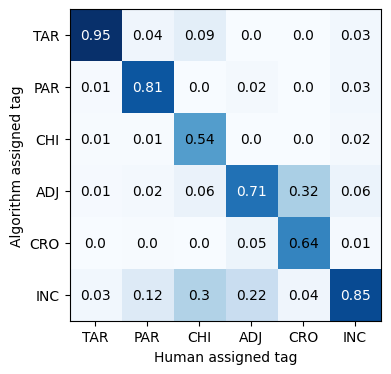

In [84]:
heat_map = np.array([list(v.values()) for k,v in category_guesses.items()])
tags = list(category_guesses.keys())

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(heat_map.T, cmap='Blues')
ax.set_xticks(np.arange(len(tags)), labels=tags)
ax.set_yticks(np.arange(len(tags)), labels=tags)

ax.set_xlabel('Human assigned tag')
ax.set_ylabel('Algorithm assigned tag')
# Loop over data dimensions and create text annotations.
for i, hum_tag in enumerate(tags):
    for j, alg_tag in enumerate(tags):
        val = category_guesses[alg_tag][hum_tag]
        if val > 0.7:
            text = ax.text(j, i, np.round(val,2), ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, np.round(val,2), ha="center", va="center", color="k") 
fig.tight_layout()
plt.show()   

fig.savefig('../results/fig_1.pdf')              
                